In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from time import time
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
import os
warnings.filterwarnings('ignore')


In [8]:
class MovieGenreClassifier:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=5000,
            stop_words='english',
            ngram_range=(1, 2),
            min_df=2,
            max_df=0.95
        )
        self.models = {
            'Naive Bayes': MultinomialNB(),
            'Logistic Regression': LogisticRegression(max_iter=1000, multi_class='ovr'),
            'SVM': LinearSVC(max_iter=1000)
        }
        self.results = {}
        self.trained_models = {}
        self.lemmatizer = WordNetLemmatizer()

    def preprocess_text(self, text):
        """Clean and preprocess text data"""
        try:
            text = str(text).lower()
            text = re.sub(r'[^a-zA-Z\s]', ' ', text)
            tokens = word_tokenize(text)
            stop_words = set(stopwords.words('english'))
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
            tokens = [token for token in tokens if len(token) > 2]
            return ' '.join(tokens)
        except Exception as e:
            print(f"Error in text preprocessing: {str(e)}")
            return text

    def load_and_preprocess_data(self, file_path):
        """Load and preprocess the movie data"""
        try:
            if not os.path.exists(file_path):
                raise FileNotFoundError(f"Data file not found: {file_path}")
                
            movies = []
            genres = []
            plots = []
            
            with open(file_path, 'r', encoding='utf-8') as file:
                for line_num, line in enumerate(file, 1):
                    try:
                        parts = line.strip().split(' ::: ')
                        if len(parts) >= 3:
                            movies.append(parts[1])  # Title
                            genres.append(parts[2] if len(parts) == 4 else parts[1])  # Genre
                            plots.append(parts[-1])  # Plot
                        else:
                            print(f"Warning: Skipping malformed line {line_num} in {file_path}")
                    except Exception as e:
                        print(f"Warning: Error processing line {line_num} in {file_path}: {str(e)}")
                        continue
            
            if not movies:
                raise ValueError(f"No valid data found in {file_path}")
                
            return pd.DataFrame({
                'movie': movies,
                'genre': genres,
                'plot': plots
            })
            
        except Exception as e:
            print(f"Error loading data from {file_path}: {str(e)}")
            return None

    def plot_confusion_matrix(self, y_true, y_pred, model_name):
        """Plot confusion matrix for a model"""
        try:
            plt.figure(figsize=(10, 8))
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix - {model_name}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting confusion matrix: {str(e)}")

    def plot_model_metrics(self):
        """Plot comprehensive model comparison metrics in separate windows"""
        try:
            if not self.results:
                print("No results available for plotting. Train models first.")
                return

            models = list(self.results.keys())
            accuracies = [self.results[model]['accuracy'] for model in models]
            cv_means = [self.results[model]['cv_scores'].mean() for model in models]
            cv_stds = [self.results[model]['cv_scores'].std() for model in models]
            training_times = [self.results[model]['training_time'] for model in models]
            prediction_times = [self.results[model]['prediction_time'] for model in models]

            # 1. Accuracy Comparison
            plt.figure(figsize=(8, 6))
            x = np.arange(len(models))
            width = 0.35

            plt.bar(x - width/2, accuracies, width, label='Test Accuracy', color='skyblue')
            plt.bar(x + width/2, cv_means, width, label='CV Accuracy', color='lightgreen')
            plt.errorbar(x + width/2, cv_means, yerr=cv_stds, fmt='none', color='green', capsize=5)

            plt.title('Model Accuracy Comparison', fontsize=12)
            plt.xlabel('Models', fontsize=10)
            plt.ylabel('Accuracy', fontsize=10)
            plt.xticks(x, models, rotation=45, fontsize=9)
            plt.legend(fontsize=9)
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()

            # 2. Training Time Comparison
            plt.figure(figsize=(8, 6))
            x = np.arange(len(models))
            width = 0.35

            plt.bar(x - width/2, training_times, width, label='Training Time', color='coral')
            plt.bar(x + width/2, prediction_times, width, label='Prediction Time', color='purple')

            plt.title('Model Time Performance', fontsize=12)
            plt.xlabel('Models', fontsize=10)
            plt.ylabel('Time (seconds)', fontsize=10)
            plt.xticks(x, models, rotation=45, fontsize=9)
            plt.legend(fontsize=9)
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()

            # 3. Combined Metrics
            plt.figure(figsize=(8, 6))
            max_time = max(max(training_times), max(prediction_times))
            norm_training_times = [t/max_time for t in training_times]
            norm_prediction_times = [t/max_time for t in prediction_times]

            width = 0.25
            x = np.arange(len(models))

            plt.bar(x - width, accuracies, width, label='Accuracy', color='skyblue')
            plt.bar(x, norm_training_times, width, label='Norm. Training Time', color='coral')
            plt.bar(x + width, norm_prediction_times, width, label='Norm. Prediction Time', color='purple')

            plt.title('Combined Performance Metrics', fontsize=12)
            plt.xlabel('Models', fontsize=10)
            plt.ylabel('Normalized Score', fontsize=10)
            plt.xticks(x, models, rotation=45, fontsize=9)
            plt.legend(fontsize=9)
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.tight_layout()
            plt.show()

            # 4. Performance Summary Table
            plt.figure(figsize=(8, 3))
            plt.axis('tight')
            plt.axis('off')

            data = []
            columns = ['Model', 'Accuracy', 'CV Score', 'Train Time', 'Predict Time']

            for model in models:
                data.append([
                    model,
                    f"{self.results[model]['accuracy']:.4f}",
                    f"{self.results[model]['cv_scores'].mean():.4f}",
                    f"{self.results[model]['training_time']:.2f}s",
                    f"{self.results[model]['prediction_time']:.2f}s"
                ])

            table = plt.table(cellText=data, colLabels=columns, cellLoc='center', 
                             loc='center', colColours=['lightgray']*5)
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1.2, 1.5)
            plt.title('Performance Summary Table', fontsize=12)
            plt.tight_layout()
            plt.show()

            # Print detailed metrics
            print("\nDetailed Model Performance Metrics:")
            print("=" * 80)
            print(f"{'Model':<20} {'Accuracy':<10} {'CV Score':<15} {'Train Time':<12} {'Predict Time':<12}")
            print("-" * 80)

            for model in models:
                print(f"{model:<20} "
                      f"{self.results[model]['accuracy']:.4f}     "
                      f"{self.results[model]['cv_scores'].mean():.4f} ± {self.results[model]['cv_scores'].std():.4f}    "
                      f"{self.results[model]['training_time']:.2f}s        "
                      f"{self.results[model]['prediction_time']:.2f}s")

        except Exception as e:
            print(f"Error plotting model metrics: {str(e)}")

    def plot_detailed_time_analysis(self):
        """Plot detailed time analysis for models"""
        try:
            if not self.results:
                print("No results available for plotting. Train models first.")
                return
                
            models = list(self.results.keys())
            training_times = [self.results[model]['training_time'] for model in models]
            prediction_times = [self.results[model]['prediction_time'] for model in models]
            
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Training Time Analysis
            sns.barplot(x=models, y=training_times, ax=ax1, palette='viridis')
            ax1.set_title('Training Time Comparison', fontsize=12)
            ax1.set_xlabel('Models', fontsize=10)
            ax1.set_ylabel('Training Time (seconds)', fontsize=10)
            ax1.tick_params(axis='x', rotation=45, labelsize=9)
            
            for i, v in enumerate(training_times):
                ax1.text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontsize=9)
            
            # Prediction Time Analysis
            sns.barplot(x=models, y=prediction_times, ax=ax2, palette='viridis')
            ax2.set_title('Prediction Time Comparison', fontsize=12)
            ax2.set_xlabel('Models', fontsize=10)
            ax2.set_ylabel('Prediction Time (seconds)', fontsize=10)
            ax2.tick_params(axis='x', rotation=45, labelsize=9)
            
            for i, v in enumerate(prediction_times):
                ax2.text(i, v, f'{v:.2f}s', ha='center', va='bottom', fontsize=9)
            
            plt.tight_layout()
            plt.show()
            
            # Print time efficiency metrics
            print("\nTime Efficiency Metrics:")
            print("=" * 60)
            print(f"{'Model':<20} {'Training Time':<15} {'Prediction Time':<15}")
            print("-" * 60)
            
            for model in models:
                print(f"{model:<20} "
                      f"{self.results[model]['training_time']:.2f}s           "
                      f"{self.results[model]['prediction_time']:.2f}s")
                      
        except Exception as e:
            print(f"Error plotting time analysis: {str(e)}")

    def train_and_evaluate(self, data_dir=None):
        """Train and evaluate models"""
        if data_dir is None:
            data_dir = "C:/Users/LENOVO/Desktop/TASK1_MOVIE_GENRE"
            
        try:
            train_path = os.path.join(data_dir, "train_data.txt")
            test_path = os.path.join(data_dir, "test_data.txt")
            solution_path = os.path.join(data_dir, "test_data_solution.txt")
            
            print("Loading and preprocessing data...")
            
            train_df = self.load_and_preprocess_data(train_path)
            test_df = self.load_and_preprocess_data(test_path)
            solution_df = self.load_and_preprocess_data(solution_path)
            
            if train_df is None or test_df is None or solution_df is None:
                raise ValueError("Failed to load one or more required datasets")
            
            print(f"\nDataset Information:")
            print(f"Training samples: {len(train_df)}")
            print(f"Test samples: {len(test_df)}")
            print(f"Unique genres: {train_df['genre'].nunique()}")
            
            print("\nPreprocessing text data...")
            train_df['processed_plot'] = train_df['plot'].apply(self.preprocess_text)
            test_df['processed_plot'] = test_df['plot'].apply(self.preprocess_text)
            
            print("Vectorizing text data...")
            X_train = self.vectorizer.fit_transform(train_df['processed_plot'])
            X_test = self.vectorizer.transform(test_df['processed_plot'])
            y_train = train_df['genre']
            y_test = solution_df['genre']
            
            for name, model in self.models.items():
                try:
                    print(f"\nTraining {name}...")
                    start_time = time()
                    
                    model.fit(X_train, y_train)
                    self.trained_models[name] = model
                    training_time = time() - start_time
                    
                    start_time = time()
                    y_pred = model.predict(X_test)
                    prediction_time = time() - start_time
                    
                    accuracy = accuracy_score(y_test, y_pred)
                    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
                    
                    self.results[name] = {
                        'accuracy': accuracy,
                        'cv_scores': cv_scores,
                        'training_time': training_time,
                        'prediction_time': prediction_time,
                        'predictions': y_pred,
                        'true_labels': y_test
                    }
                    
                    print(f"Results for {name}:")
                    print(f"Accuracy: {accuracy:.4f}")
                    print(f"Cross-validation: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
                    print(f"Training Time: {training_time:.2f}s")
                    print(f"Prediction Time: {prediction_time:.2f}s")
                    
                    # Plot confusion matrix for the model
                    self.plot_confusion_matrix(y_test, y_pred, name)
                    
                except Exception as e:
                    print(f"Error training {name}: {str(e)}")
            
            # Plot comprehensive model metrics
            self.plot_model_metrics()
            self.plot_detailed_time_analysis()
            
        except Exception as e:
            print(f"Error in train_and_evaluate: {str(e)}")

    def predict_genre(self, text, correct_model=None):
        """Predict the genre of a given text using all trained models and highlight the correct model's prediction (if provided)"""
        if not self.trained_models:
            raise ValueError("No models have been trained yet. Call train_and_evaluate first.")
        
        try:
            # Preprocess the input text
            processed_text = self.preprocess_text(text)
            # Vectorize the text
            text_vector = self.vectorizer.transform([processed_text])
            # Predict the genre using all models
            predictions = {}
            for model_name, model in self.trained_models.items():
                predictions[model_name] = model.predict(text_vector)[0]
            
            # Display predictions and highlight the correct model's prediction
            print("\nPredicted Genres by All Models:")
            for model_name, genre in predictions.items():
                if correct_model and model_name == correct_model:
                    print(f"{model_name}: \033[1;32m{genre}\033[0m")  # Highlight correct model's prediction in green
                else:
                    print(f"{model_name}: {genre}")
            
            return predictions
        except Exception as e:
            print(f"Error predicting genre: {str(e)}")
            return None

In [9]:
# Initialize the classifier
classifier = MovieGenreClassifier()

Loading and preprocessing data...

Dataset Information:
Training samples: 54214
Test samples: 54200
Unique genres: 27

Preprocessing text data...
Vectorizing text data...

Training Naive Bayes...
Results for Naive Bayes:
Accuracy: 0.5254
Cross-validation: 0.5220 (+/- 0.0033)
Training Time: 0.60s
Prediction Time: 0.12s


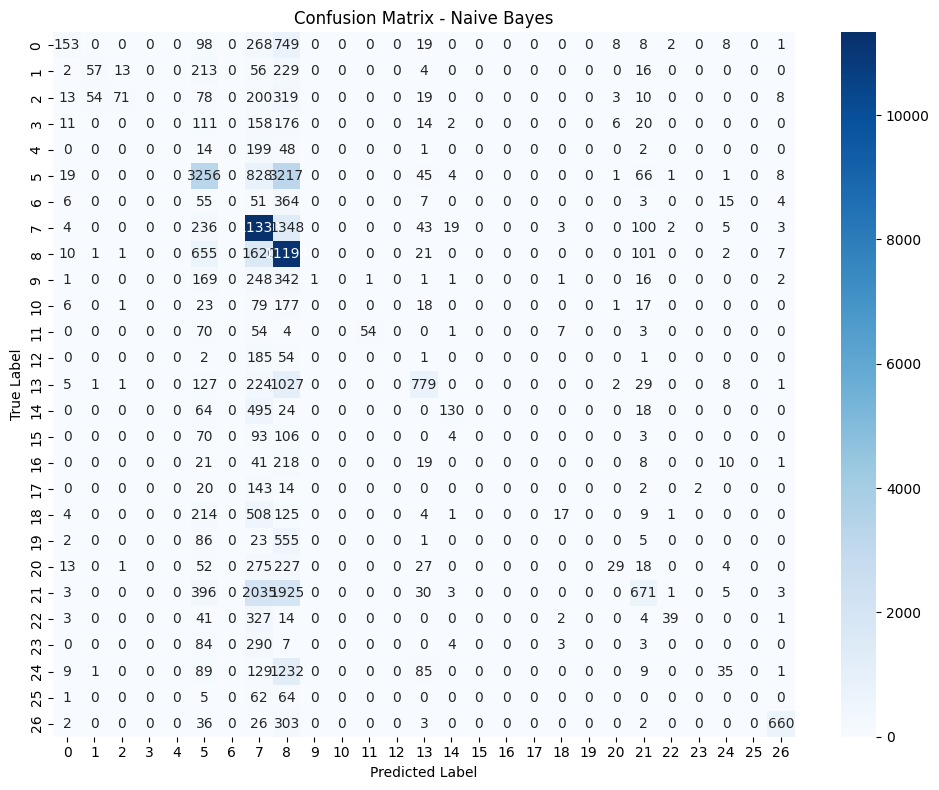


Training Logistic Regression...
Results for Logistic Regression:
Accuracy: 0.5820
Cross-validation: 0.5781 (+/- 0.0054)
Training Time: 20.71s
Prediction Time: 0.08s


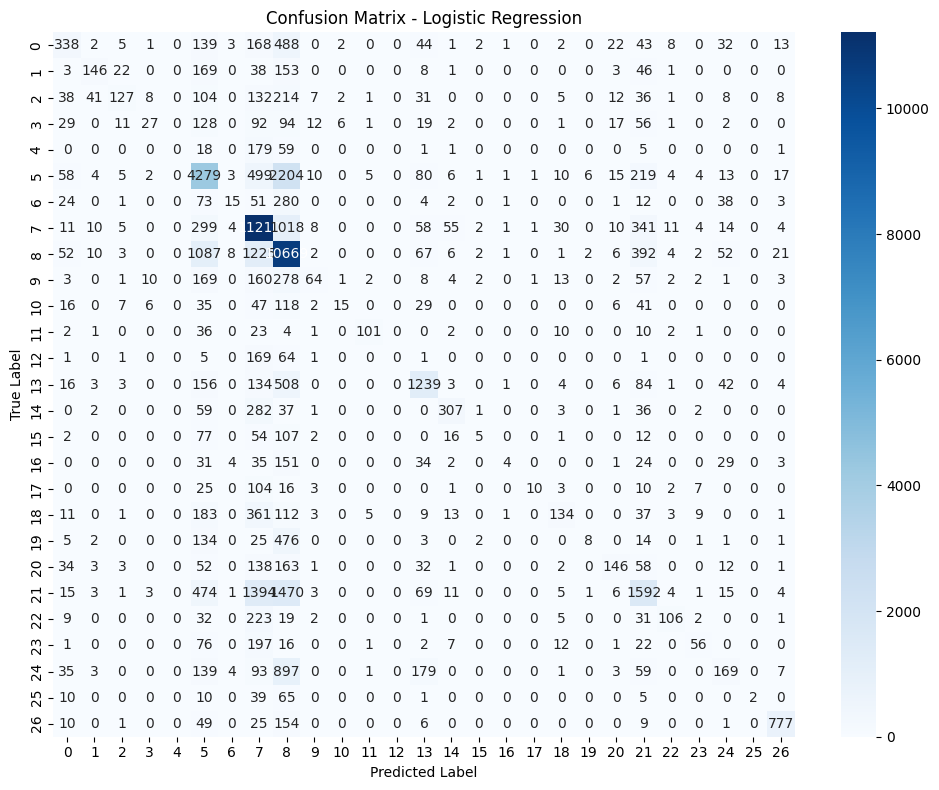


Training SVM...
Results for SVM:
Accuracy: 0.5733
Cross-validation: 0.5683 (+/- 0.0058)
Training Time: 16.54s
Prediction Time: 0.05s


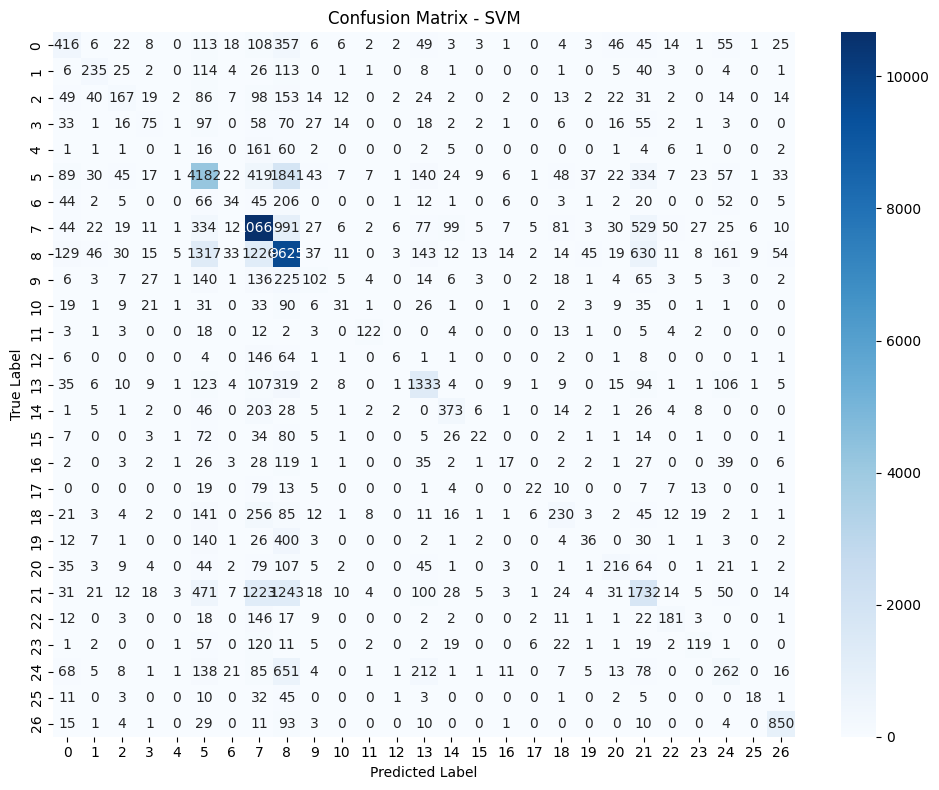

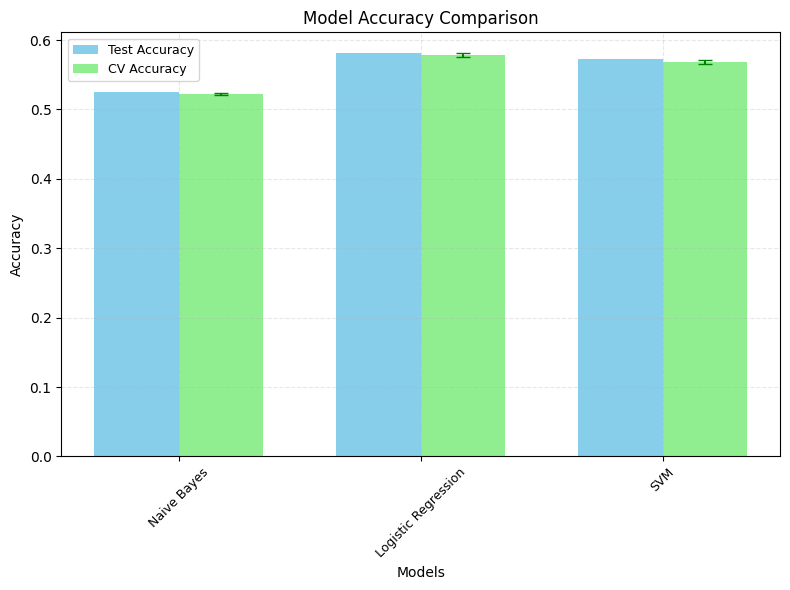

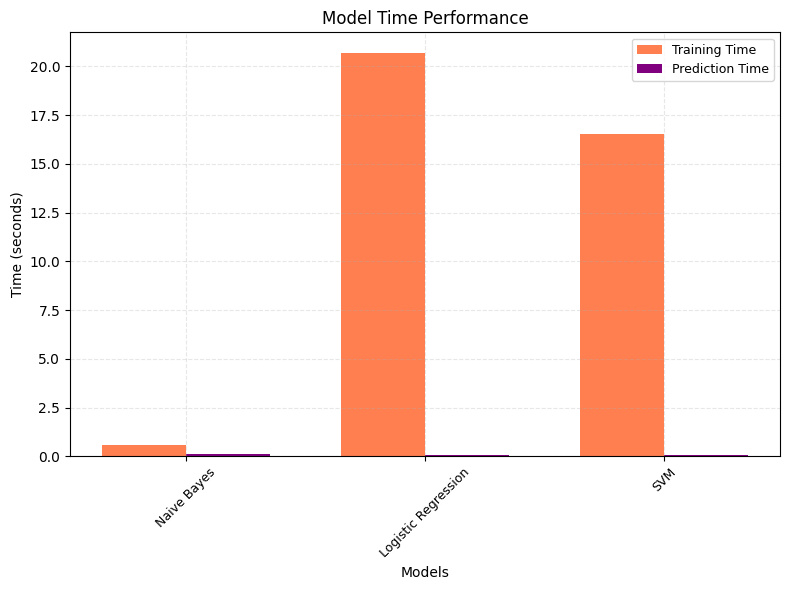

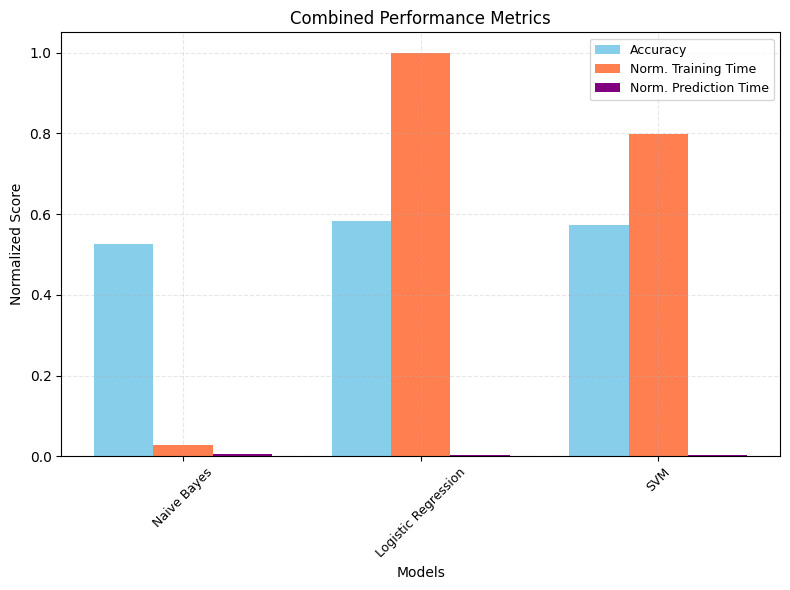

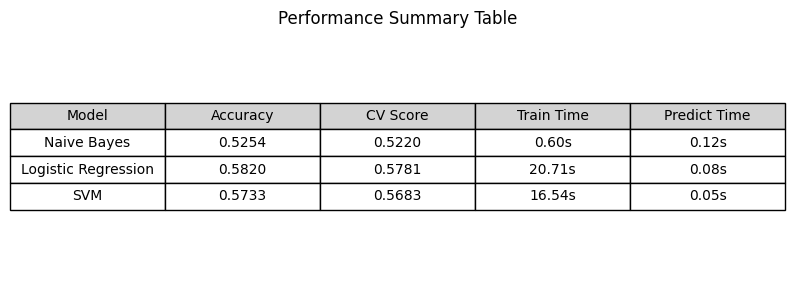


Detailed Model Performance Metrics:
Model                Accuracy   CV Score        Train Time   Predict Time
--------------------------------------------------------------------------------
Naive Bayes          0.5254     0.5220 ± 0.0016    0.60s        0.12s
Logistic Regression  0.5820     0.5781 ± 0.0027    20.71s        0.08s
SVM                  0.5733     0.5683 ± 0.0029    16.54s        0.05s


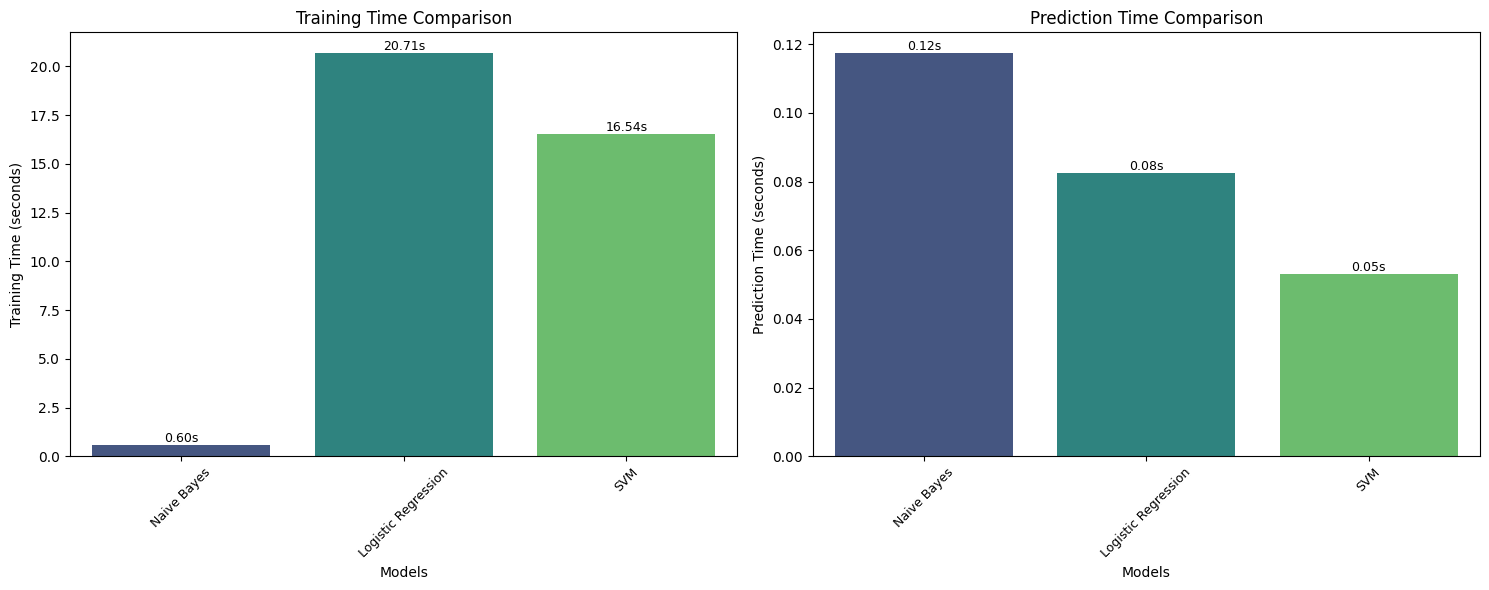


Time Efficiency Metrics:
Model                Training Time   Prediction Time
------------------------------------------------------------
Naive Bayes          0.60s           0.12s
Logistic Regression  20.71s           0.08s
SVM                  16.54s           0.05s


In [10]:
# Train and evaluate models
classifier.train_and_evaluate(data_dir="C:/Users/LENOVO/Desktop/TASK1_MOVIE_GENRE")

In [11]:
# Example usage of predict_genre
sample_text = "A young boy discovers he is a wizard and is invited to attend a magical school. There, he learns about his destiny to fight against a dark wizard who seeks to dominate the magical world. Alongside his friends, he uncovers secrets about his past and faces numerous challenges to protect the wizarding world."
correct_model = "Logistic Regression"  
predicted_genres = classifier.predict_genre(sample_text, correct_model=correct_model)


Predicted Genres by All Models:
Naive Bayes: drama
Logistic Regression: fantasy
SVM: family
